## Financial Stock Analysis
**Matthew Bates & Sankeerti Haniyur.** 
*Final project for STA 148B 'Data Science', Winter 2017*

**Introduction:** The functions demonstrated in this notebook can be used to download stock price data from Yahoo Finance, calculate n-day trailing percent or log returns, and plot the results of those calculations. These functions will all be defined first and then demonstrated once, together at the bottom of the page. Having all of this code defined in separate functions will make it easy to import later as a package from a .py file without needed to clutter the markdown file.  This markdown files demonstrate their development and use.

For theory on why the lognormal distribution is often used to describe stock returns, see discussions here [here](https://quantivity.wordpress.com/2011/02/21/why-log-returns/), [here](www.insight-things.com/log-normal-distribution-mistaken), [here](http://stats.stackexchange.com/questions/125761/why-stock-prices-are-lognormal-but-stock-returns-are-normal), & [here](https://www.quora.com/Why-do-people-use-log-returns-of-stock-prices-for-autoregression). (Note, the lognormal distribution is a useful but imperfect since actual returns are still leptokurtic, as shown in the plots at bottom.)

**Import Packages:** First, we need to import the pakages that we will use.

In [2]:
#Import packages
import urllib                               #for making web requests
import numpy as np                          #for data arrays and processing
import pandas as pd                         #for dataframes and processing
import matplotlib.mlab as mlab              #for fitting the best Gaussian curve
import matplotlib.pyplot as plt             #for plotting histograms and curves
import datetime as DT                       #for manipulating datetimes
from matplotlib.dates import date2num       #for plotting datetimes
from matplotlib.dates import DateFormatter  #for plotting datetimes
%matplotlib inline 
plt.style.use('ggplot')                     #set ploting style

**Retrieve Stock Prices:** Now, let's create a function that can download a time series of adjusted closing prices for publicly traded stocks.

In [53]:
def getYahooFinanceStockData(stock = '^GSPC', fromMonth = '01', fromDay = '01', fromYear = '1960'):
    '''
    Description: Function to get historical stock data from Yahoo Finance
    Input: a string with the stock symbol (in the format known to Yahoo Finance; defaults to the symbol for the S&P 500;
     strings for the two-digit day, two-digit month, and four-digit year from which to pull data until present (defaults to 01-01-1960).
    Output: a numpy array of string dates (for market closing events), a numpy array of real number adjusted closing prices on those dates.
    Note: the returned dates and prices are indexed from 0 = most recent clsoing price to max = earliest closing price available or found in period.'''

    #build the url and read the full contents as a string (going back in time upto start of specified year)
    url = 'http://ichart.finance.yahoo.com/table.csv?s=' + stock + '&a=' + fromMonth + '&b=' + fromDay + '&c=' + fromYear
    fulltext = urllib.request.urlopen(url).read().decode('utf-8')
  
    #split the fulltext into individual lines based on the newline character
    fulltextlines = fulltext.splitlines()

    #split the lines into headers and an array of data, based by comma characters
    header = fulltextlines[0].split(',')    #for now, fine to just discard the header...
    data = np.array([line.split(',') for line in fulltextlines[1:]])
  
    #note, if you wanted to return reported closing values instead of adjusted closing values, use column data[4] instead of data[6].
    adjustedClosingPrices = data[:,6].astype(np.float)  #convert it to an array of floats instead of strings.
    ##adjustedClosingPrices = np.array(list(map(float, data[:,6])))
    ##adjustedClosingPrices = data[:,6]
    closing_dates = data[:,0]
  
    return closing_dates, adjustedClosingPrices

**Calculate (Lognormal) Stock Returns:** Next, let's define a function that calculates lognormal stock returns for each closing date in. a time series, over the past *n* days.

In [4]:
def calcLogNormalStockReturns(stockPrices = np.empty(0), n_days=1):   
    '''
    Description: calcualtes the lognormal return from a specified stock over n days; is an alternative to fn: calcPercentStockReturns().
    Input: a numpy array of real number stock prices over time (defaults to an empty array); and an integer 
     for the number of days difference in the past to use in calculating the trailing returns (defaults to one day prior)
    Output: a list of real numbers for lognormal stock returns over the previous n days, for each day in the initial array.
    Note: there are an avg of 5 trading days per week, 21 trading days per month, 252 trading days per year.'''

    #COMPUTE THE N-DAY TRAILING PERCENT RETURNS  
    n_day_lognormal_returns = np.empty(len(stockPrices) - n_days)
    for i in range(len(stockPrices) - n_days):      #n-day training return; use "-n" to omit oldest n days that won't have a pair with which to compare
        n_day_lognormal_returns[i] = np.log(float(stockPrices[i]) / float(stockPrices[i+n_days]))
  
    return n_day_lognormal_returns

**Calculate (Percent) Stock Returns:** Let's also give ourselves the ability to generate a time series of percent returns (which should be almost identical, just in case we will ever want that.

In [5]:
def calcPercentStockReturns(stockPrices = np.empty(0), n_days=1):   
    '''
    Description: calcualtes the percent return from a specified stock over n days
    Input: a numpy array of real number stock prices over time (defaults to an empty array); and an integer 
     for the number of days difference in the past to use in calculating the trailing returns (defaults to one day prior)
    Output: a numpy array of real numbers for the percent returns over the previous n days, for each day in the initial array.
    Note: there are an avg of 5 trading days per week, 21 trading days per month, 252 trading days per year.'''

    #COMPUTE THE N-DAY TRAILING PERCENT RETURNS
    n_day_percent_returns = np.empty(len(stockPrices) - n_days)
    for i in range(len(stockPrices) - n_days):     #n-day training return; use "-n" to omit oldest n days that won't have a pair with which to compare
        n_day_percent_returns[i] = (float(stockPrices[i]) - float(stockPrices[i+n_days])) / float(stockPrices[i+n_days]) *100
  
    return n_day_percent_returns

**Plot Stock Prices and Returns:** Next, let's create a function that can plot the time series of stock adjusted closing prices, calculated lognormal or percent returns, and plot a histogram and gaussian curve of best fit for the resulting distributions. 

In [6]:
def plotStockReturns(stock_name, closing_dates, stock_prices, stock_returns, n_days, isLognormal):

    ## PLOT STOCK ADJUSTED CLOSING PRICE HISTORY ##
    pltdata = []
    for i in range(len(stock_prices)):
        pltdata.append((DT.datetime.strptime(closing_dates[i], "%Y-%m-%d"), stock_prices[i]))
                
    x = [date2num(date) for (date, value) in pltdata]
    y = [value for (date, value) in pltdata]
  
    fig, ax = plt.subplots()
    ax.plot(x,y, linewidth=0.5)
    ax.xaxis.set_major_formatter(DateFormatter('%d %b %Y')) #('%b %d %Y'))
    ax.xaxis_date()  #tell matplotlib to interpret the x-axis values as dates
    plt.gcf().autofmt_xdate(rotation=45) #rotate the x labels
    plt.title('Stock ' + stock_name + ': adjusted closing price')  
    plt.ylabel('adjusted closing price ($)')
    plt.xlabel('dates prior to the present')
    plt.show()


    ## PLOT STOCK CALCUALTED N-DAY PERCENT TRAILING RETURNS ##
    pltdata = []
    for i in range(len(stock_returns)):
        pltdata.append((DT.datetime.strptime(closing_dates[i], "%Y-%m-%d"), stock_returns[i]))
                
    x = [date2num(date) for (date, value) in pltdata]
    y = [value for (date, value) in pltdata]
  
    fig, ax = plt.subplots()
    ax.plot(x,y, linewidth=0.5)
    ax.xaxis.set_major_formatter(DateFormatter('%d %b %Y')) #('%b %d %Y'))
    ax.xaxis_date()  #tell matplotlib to interpret the x-axis values as dates
    plt.gcf().autofmt_xdate(rotation=45) #rotate the x labels
    if isLognormal:
        plt.title('Stock ' + stock_name + ': '+ str(n_days) +'-day trailing returns (lognormal)'
        + '\n(greatest lognormal drawdown in this period was ' + '%.2f' % min(stock_returns) +')')  
        plt.ylabel(str(n_days) + '-day lognormal return')
    else:
        plt.title('Stock ' + stock_name + ': '+ str(n_days) +'-day trailing returns (%)'
        + '\n(greatest percent drawdown in this period was ' + '%.2f' % min(stock_returns) + '%)')  
        plt.ylabel(str(n_days) + '-day percent return')
    plt.xlabel('dates prior to the present')
    plt.show()


    ## PLOT THE HISTOGRAM FOR THE RETURNS DATA AND A GAUSSIAN CURVE OF BEST FIT ##
    #generate the histogram and save the parameters for our line of best fit.
    n, bins, patches = plt.hist(stock_returns, bins=100, normed=True, alpha=0.4)
  
    #generate the Gaussian line of best fit for the histogram.
    y = mlab.normpdf(bins, np.mean(stock_returns), np.std(stock_returns, ddof=1))
    l = plt.plot(bins, y, 'r--', linewidth=2)
  
    #add labels and plot the histogram and Gaussian line of best fit.
    plt.title("Stock: " + stock_name + ": histogram and Gaussian curve of best fit")
    if isLognormal:
        plt.xlabel("bins for lognormal " + str(n_days) + "-day returns")
    else:
        plt.xlabel("bins for percent " + str(n_days) + "-day returns")      
        plt.ylabel("relative proportion of returns within each bin")
        #plt.axis([-.25, .25, 0, 1])
    plt.grid(True)
    plt.show()
  
    if isLognormal:
        print("Mean  of distribution of", n_days, "-day lognormal returns:", np.mean(stock_returns))
        print("StDev of distribution of", n_days, "-day lognormal returns:", np.std(stock_returns, ddof=1), "\n")
    else:
        print("Mean  of distribution of", n_days, "-day percent returns:", np.mean(stock_returns))
        print("StDev of distribution of", n_days, "-day percent returns:", np.std(stock_returns, ddof=1), "\n")


And demonstrate the code above for some sample stocks...


Test results for stock PERCENT returns (similar, less likely to be used):


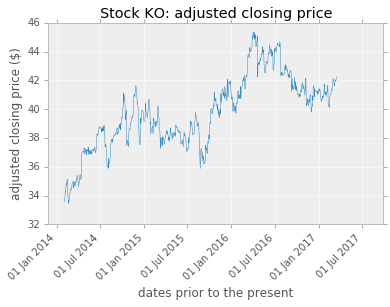

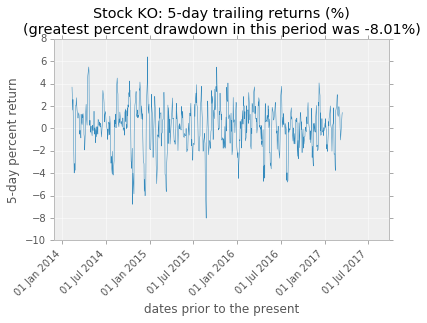

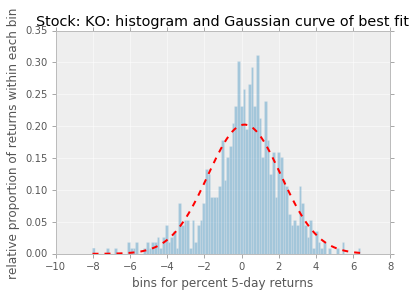

Mean  of distribution of 5 -day percent returns: 0.156363042035
StDev of distribution of 5 -day percent returns: 1.96878243901 


Test results for LOGNORMAL stock returns (method most likely to be used):


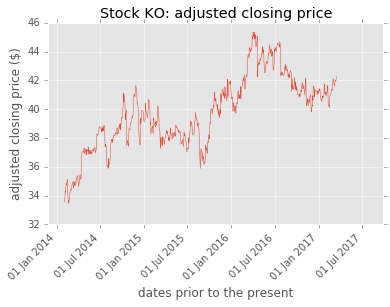

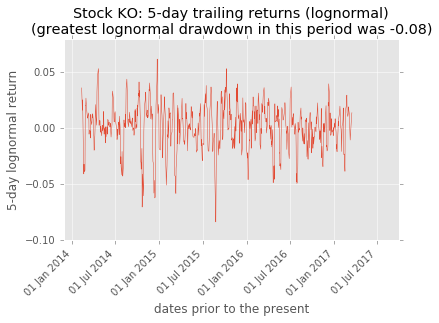

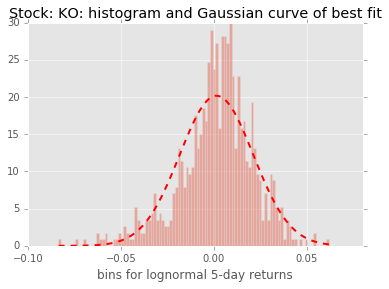

Mean  of distribution of 5 -day lognormal returns: 0.00136791145766
StDev of distribution of 5 -day lognormal returns: 0.0197764586083 



In [54]:
##### TEST IT FOR SOME SAMPLE STOCKS #####

#test the functions created for pulling and analyzing stock data for handful of example stocks.
stocks=['KO']
#stocks = ['WMT','GS','XOM','FB','NKE']
n_days = 5
month = '1'
day = '1'
year = '2014'

plt.style.use('bmh')                        #set ploting style
print('\nTest results for stock PERCENT returns (similar, less likely to be used):')
for stock in stocks:  
    closing_dates, stock_prices = getYahooFinanceStockData(stock, month, day, year)
    stock_returns = calcPercentStockReturns(stock_prices, n_days)
    plotStockReturns(stock, closing_dates, stock_prices, stock_returns, n_days, False)
    
    
print('\nTest results for LOGNORMAL stock returns (method most likely to be used):')
plt.style.use('ggplot')                     #set different ploting style
for stock in stocks:  
    closing_dates, stock_prices = getYahooFinanceStockData(stock, month, day, year)
    stock_returns = calcLogNormalStockReturns(stock_prices, n_days)
    plotStockReturns(stock, closing_dates, stock_prices, stock_returns, n_days, True)

(Notice that stock prices are all leptokurtic (i.e., the distribution shown by the histograms is narrower near the mean than its Gaussian of best of fit, and correspondingly also has fatter tails. Thus, to model stock returns as normal would underestimate the risk of extreme events.)

**Helper Function (Find Preceding Sunday):** Helper function to return a datetime object for the preceding Sunday. (If input datetime is a Sunday, return the same datetime.)

In [29]:
def precedingSunday(d):
    '''a small helper fuction. input: datetime. output: datetime for preceding sunday; if d is a sunday, return d.'''
    #Note, for datetime.weekday: sunday=6, monday=0, tuesday=1, wedesday=2, thursday=3, friday=4, saturday=5.
    if d.weekday() == 6: 
        return d
    else: 
        return d - DT.timedelta(days = d.weekday() + 1)

**Avg Returns Per Week, Reordered & Relabeled:** This function does 3 specific things: 1) It reverse the order of the entries in the array so that the oldest are first, to match the order of the data we retrieve from Google Trends data. (We are working with weekly Google Trends data to smooth over weekday/weekend differences in search frequency.) 2) It uses this daily time series of n-day returns and creates an average weekly time series of n-day returns. (This is complicated because weeks that have holidays do not have the same number of trading days as normal weeks, so we actually have to interpret the weekdays and not just count off groups of five.) 3) It reorganizes the date labels for the weekly average time series so that thay are referenced from the Sunday starting the week (to match the Google Trends data format) instead of the Monday startin the training period (as supplied in the Yahoo Finance data set).

In [57]:
def avgWeeklyAndReorder(in_dates = np.empty(0), in_returns = np.empty(0)):
    '''Definition: Take an array of daily stock returns and returns an array of average weekly stock returns in reverse order, labeled from Sundays.
    Input: a numpy array of daily real number n-day stock returns, with oldest values last; a corresponding numpy array of string dates.
    Output a numpy array of weekly average real number n-day stock returns, with oldest values first (to match order of Google Trends data)
     a numpy array of corresponding string dates (referenced by the preceding Sunday)
    Note: assumes the oldest date in the daily returns input array is a Monday.'''
    
    #reverse the input arrays to be oldest first, convert string dates to datetime objects
    dates = np.array([DT.datetime.strptime(d, "%Y-%m-%d") for d in in_dates[::-1]])
    returns = in_returns[::-1]
    
    
    #identify the Sundays before the first and last dates in our input time series (of weekdays), and # of weeks between
    oldestSun = precedingSunday(dates[0])
    newestSun = precedingSunday(dates[len(dates)-1])
    weeksBetween = int((newestSun - oldestSun).days / 7)
    
    #create an array of datetimes for all Sundays beginning a trading week in our dataset (and empty array for its avg returns)
    weeks = np.array([oldestSun + DT.timedelta(days = 7 * w) for w in range(weeksBetween)])
    wreturns = np.empty(len(weeks))
    
    #print(newestSun, oldestSun, weeksBetween, '\n')
    #for d in dates: print(d)
    #for w in weeks: print(w)

    #average the n-day returns across each day in the week, for all weeks (note weeks with holidays have fewer trading days)
    w, wsum, count = 0,0,0
    for i, d in enumerate(dates):
        if d < weeks[w] + + DT.timedelta(days=7):       #if day d is in week w
            count += 1                                  #increase the count of trading days in the week
            wsum += returns[i]                          #increase the sum of n-day returns in the week
        else:
            wreturns[w] = wsum / count
            count, wsum = 0,0
            w += 1
    
    for ww in wreturns: print(ww)
    

avgWeeklyAndReorder(closing_dates, stock_returns)


IndexError: index 781 is out of bounds for axis 0 with size 781

**Create Bitmask for Worst Returns in Record:**  Now let's create a function that filters our the low amplitude, high frequency returns that represent daily trading noise, and develop a binary time series of only the most substantial loss events.

In [49]:
def worstReturns(stock_returns = np.empty(0), pWorst = 5):
    '''Description: Take a time series of stock returns and return a binary time series identifying some percent of worst returns in that period.
    Input: a numpy array representing a time series (e.g., of stock returns); a real number for the percent of lowest values retain (defaults to 15%).
    Output: a numpy array representing a binary time series with 1's where lowest values occured and 0's elsewhere.
    Note: pWorst is the percent of the time series to retain; the percent of losses to retain may be about half of it.
          a pWorst value of 50 = 50%, a pWorst value of 0.5 = 0.5% < 1%.'''
    
    worst_ones = np.zeros(len(stock_returns), dtype=int)
    p = np.percentile(stock_returns, pWorst)  #identify all values less than this.
    for i in range(len(stock_returns)):
        if stock_returns[i] <= p: worst_ones[i] = 1
    
    return worst_ones

And demonstrate that function...

number of zero or one flags for worst 5% of returns: 779
number of returns in the bottom 5% (where mask == 1): 39
number of dates corresponding to the bottom 5% (where mask == 1): 39 



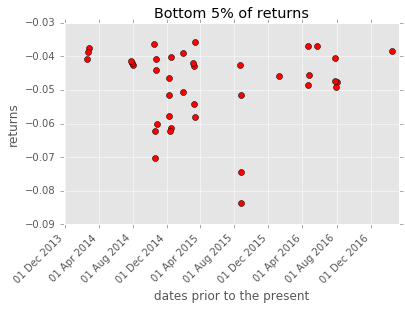

Here are the 5% worst returns from the dataset:
2017-02-15 	 -0.0383263413971
2016-08-01 	 -0.0476387280317
2016-07-29 	 -0.0491939293437
2016-07-28 	 -0.040409515771
2016-07-27 	 -0.0474725864539
2016-05-23 	 -0.0368385940156
2016-04-26 	 -0.0454374216834
2016-04-21 	 -0.0485065783545
2016-04-20 	 -0.0369470683486
2016-01-07 	 -0.0457880565568
2015-08-26 	 -0.0515772426762
2015-08-25 	 -0.0835394639767
2015-08-24 	 -0.0745358521674
2015-08-21 	 -0.0425912529434
2015-03-12 	 -0.0358560538465
2015-03-11 	 -0.0581277557007
2015-03-10 	 -0.0540543384737
2015-03-09 	 -0.0428012334177
2015-03-06 	 -0.0419773689601
2015-01-30 	 -0.0506738149948
2015-01-29 	 -0.0391293739578
2014-12-16 	 -0.040039343207
2014-12-15 	 -0.0614217596102
2014-12-12 	 -0.0620757946133
2014-12-11 	 -0.0463449173233
2014-12-10 	 -0.0515336606293
2014-12-09 	 -0.0577661284428
2014-10-27 	 -0.0602205173907
2014-10-24 	 -0.0441020621725
2014-10-23 	 -0.0407632849955
2014-10-22 	 -0.0622741588199
2014-10-21 	 -0.07023756

In [50]:
##### HERE IS SOME QUICK CODE TO DEMONSTRATE THE FUNCTION ABOVE & PLOT ITS RESULTS #####

#Run it...
bottom5Mask = worstReturns(stock_returns, 5)
bottom5Returns = np.array([r for r, mask in zip(stock_returns, bottom5Mask) if mask == 1])
bottom5Dates = np.array([d for d, mask in zip(closing_dates, bottom5Mask) if mask == 1])
print('number of zero or one flags for worst 5% of returns:', len(bottom5Mask))
print('number of returns in the bottom 5% (where mask == 1):', len(bottom5Returns))
print('number of dates corresponding to the bottom 5% (where mask == 1):', len(bottom5Dates), '\n')

#Plot it...
pltdata = []
for i in range(len(bottom5Returns)):
    pltdata.append((DT.datetime.strptime(bottom5Dates[i], "%Y-%m-%d"), bottom5Returns[i]))
x = [date2num(date) for (date, value) in pltdata]
y = [value for (date, value) in pltdata]
fig, ax = plt.subplots()
ax.plot(x,y, 'ro')
ax.xaxis.set_major_formatter(DateFormatter('%d %b %Y')) #('%b %d %Y'))
ax.xaxis_date()  #tell matplotlib to interpret the x-axis values as dates
plt.gcf().autofmt_xdate(rotation=45) #rotate the x labels
plt.title('Bottom 5% of returns')
plt.ylabel('returns')
plt.xlabel('dates prior to the present')
plt.show()

#Display it...
print('Here are the 5% worst returns from the dataset:')
for i in range(len(bottom5Returns)): print(bottom5Dates[i], '\t', bottom5Returns[i])
print('\nHere is the start of the binary bitmask that identifyies the locations of those worst returns:')
for i in range(min(len(bottom5Mask), 50)): print(bottom5Mask[i])